In [1]:
#Importing Libraries
import numpy as np
import pandas as pd 
import cv2
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns
import os 
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(os.listdir("../Malaria/cell_images"))

['Parasitized', 'Uninfected']


In [2]:
#Path for the source data folder
infected= os.listdir("../Malaria/cell_images/Parasitized/")
uninfected= os.listdir("../Malaria/cell_images/Uninfected/")

In [3]:
# augmenting images in the infected and uninfected data and appending the data and labels array.
data= []
labels= []

for i in infected:
    try:
        image= cv2.imread("D:/UTD/Spring 19/Extra/Malaria/cell_images/Parasitized/"+i)
        im_array= Image.fromarray(image, 'RGB')
        im_resize= im_array.resize((50,50))
        im_rotate45= im_resize.rotate(45)
        im_rotate75= im_resize.rotate(75)
        blur= cv2.blur(np.array(im_resize), (10,10))
        data.append(np.array(im_resize))
        data.append(np.array(im_rotate45))
        data.append(np.array(im_rotate75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
    except AttributeError:
        print("")
        
for i in uninfected:
    try:
        image= cv2.imread("D:/UTD/Spring 19/Extra/Malaria/cell_images/Uninfected/"+i)
        im_array= Image.fromarray(image, 'RGB')
        im_resize= im_array.resize((50,50))
        im_rotate45= im_resize.rotate(45)
        im_rotate75= im_resize.rotate(75)
        data.append(np.array(im_resize))
        data.append(np.array(im_rotate45))
        data.append(np.array(im_rotate75))
        labels.append(0)
        labels.append(0)
        labels.append(0)
    except AttributeError:
        print("")

In [4]:
cells= np.array(data)
labels= np.array(labels)
np.save('Cells' , cells)
np.save('Labels' , labels)

In [5]:
cells.shape, labels.shape 

((96453, 50, 50, 3), (96453,))

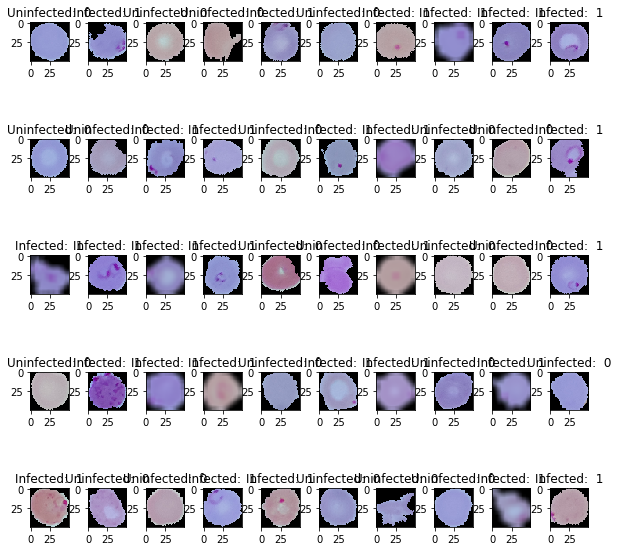

In [6]:
#Plotting random 50 images from the data
plt.figure(1,(10,10))
n= 0 
for i in range(50):
    n= n+1
    r= np.random.randint(0, cells.shape[0], 1)
    plt.subplot(5, 10, n)
    plt.subplots_adjust(hspace= 0.5, wspace= 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{}:  {}'.format('Infected' if labels[r[0]] == 1 else 'Uninfected', labels[r[0]]))
    plt.xticks()
    plt.yticks()
plt.show()

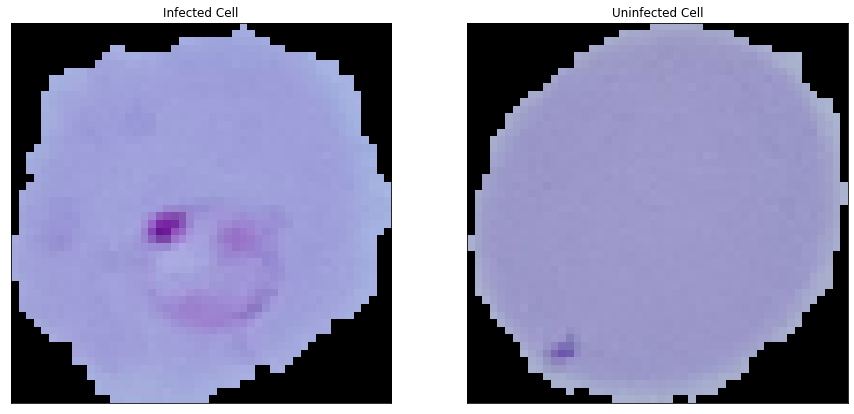

In [7]:
#Showing infected and uninfected sample images
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cells[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(cells[60000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [8]:
#shuffle the data
n= np.arange(cells.shape[0])
np.random.shuffle(n)
cells= cells[n]
labels= labels[n]

cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [9]:
#train test split with test size of 20%
train_x , x , train_y , y= train_test_split(cells , labels , test_size = 0.2 , random_state = 420)

In [10]:
#splitting test from previous split in 50% evaluation and test set
eval_x, test_x, eval_y, test_y= train_test_split(x, y, test_size= 0.5, random_state= 420)

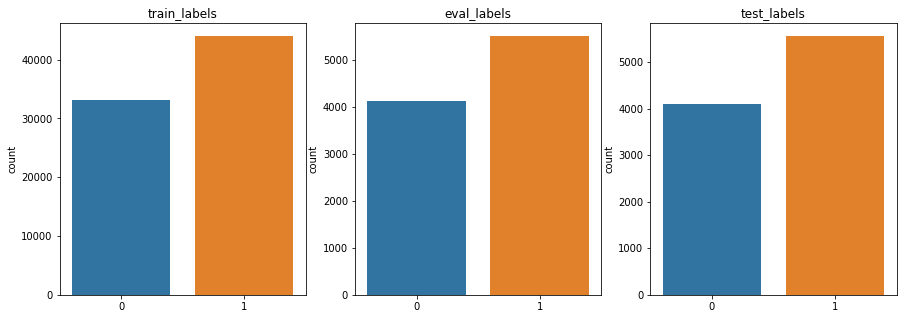

In [16]:
plt.figure(1, figsize=(15, 5))
n= 0
for z, j in zip([train_y, eval_y, test_y], ['train_labels', 'eval_labels', 'test_labels']):
    n+=1
    plt.subplot(1, 3, n)
    sns.countplot(x= z)
    plt.title(j)
plt.show()

In [11]:
train_x.shape, eval_x.shape, test_x.shape

((77162, 50, 50, 3), (9645, 50, 50, 3), (9646, 50, 50, 3))

In [12]:
#resets the global default graph
tf.reset_default_graph()
#Function for all the neural network layers
def cnn_model(features, labels, mode):
    #Conv and pool layers 
    input_layers= tf.reshape(features['x'], [-1, 50, 50, 3])
    conv1= tf.layers.conv2d(inputs= input_layers, filters= 50, kernel_size= [7 , 7], padding= 'same', activation= tf.nn.relu)
    conv2= tf.layers.conv2d(inputs= conv1, filters= 90, kernel_size= [3, 3], padding= 'valid', activation= tf.nn.relu)
    conv3= tf.layers.conv2d(inputs= conv2, filters= 10, kernel_size= [5, 5], padding= 'same', activation= tf.nn.relu)
    
    pool1= tf.layers.max_pooling2d(inputs= conv3, pool_size= [2, 2], strides= 2)
    
    conv4= tf.layers.conv2d(inputs= pool1, filters= 5, kernel_size= [3, 3], padding= 'same', activation= tf.nn.relu)
    
    pool2= tf.layers.max_pooling2d(inputs= conv4, pool_size= [2, 2], strides= 2, padding= 'same')
    
    #Flattening the output
    pool_flatten= tf.layers.flatten(pool2)
    #Fully Connected Layers having 2000,1000,500 units and relu activation function
    fc1= tf.layers.dense(inputs= pool_flatten, units= 2000, activation= tf.nn.relu)
    fc2= tf.layers.dense(inputs= fc1, units= 1000, activation= tf.nn.relu)
    fc3= tf.layers.dense(inputs= fc2, units= 500, activation= tf.nn.relu)
    #fc4= tf.layers.dense(inputs= fc3, units= 100, activation= tf.nn.relu)
    #Layer with 2 units classifying as infected and uninfected
    logits= tf.layers.dense(inputs= fc3, units =2) 
    
    predictions= {
        'classes': tf.argmax(input= logits, axis= 1),
        'probabilities': tf.nn.softmax(logits, name= 'softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT: 
        return tf.estimator.EstimatorSpec(mode= mode, predictions= predictions)
    #Loss function used Sparse Softmax Cross Entropy
    loss= tf.losses.sparse_softmax_cross_entropy(labels= labels, logits= logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer= tf.train.GradientDescentOptimizer(learning_rate= 0.001)
        train_op = optimizer.minimize(loss= loss, global_step= tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode= mode, loss= loss, train_op= train_op)
    
    eval_metric_op = {'accuracy' : tf.metrics.accuracy(labels= labels, predictions=  predictions['classes'])}
    
    return tf.estimator.EstimatorSpec(mode= mode, loss= loss, eval_metric_ops= eval_metric_op)   

In [13]:
malaria_detector = tf.estimator.Estimator(model_fn = cnn_model, model_dir = '/tmp/modelchkpt')

In [14]:
tensors_to_log = {'probabilities':'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(tensors= tensors_to_log, every_n_iter= 50)      

In [15]:
train_input_fn= tf.estimator.inputs.numpy_input_fn(x = {'x': train_x}, y= train_y, batch_size= 100, num_epochs= None, shuffle= True)
malaria_detector.train(input_fn = train_input_fn , steps = 1 , hooks = [logging_hook])

W1021 09:58:40.784848 13424 deprecation.py:323] From d:\software\python3\lib\site-packages\tensorflow\python\training\training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W1021 09:58:40.804795 13424 deprecation.py:323] From d:\software\python3\lib\site-packages\tensorflow_estimator\python\estimator\inputs\queues\feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W1021 09:58:40.808784 13424 deprecation.py:323] From d:\software\python3\lib\site-packages\tensorflow_estimator\python\estimator\inputs\queues\feeding_functions.py:500: add_queue_runner (from tensorflow.pyt

In [17]:
malaria_detector.train(input_fn = train_input_fn , steps = 10000)

In [18]:
eval_input_fn= tf.estimator.inputs.numpy_input_fn(x= {'x': eval_x}, y= eval_y, num_epochs= 1, shuffle = False)
eval_results= malaria_detector.evaluate(input_fn= eval_input_fn)
print(eval_results)

{'accuracy': 0.93001556, 'loss': 0.18294172, 'global_step': 29597}


In [19]:
pred_input_fn= tf.estimator.inputs.numpy_input_fn(x= {'x': test_x}, y= test_y, num_epochs= 1, shuffle= False)
pred_results= malaria_detector.predict(input_fn= pred_input_fn)
classes = [p['classes'] for p in pred_results]

In [20]:
confusion_matrix(test_y, classes)

array([[3773,  314],
       [ 370, 5189]], dtype=int64)

In [21]:
classification_report(test_y, classes)

'              precision    recall  f1-score   support\n\n           0       0.91      0.92      0.92      4087\n           1       0.94      0.93      0.94      5559\n\n    accuracy                           0.93      9646\n   macro avg       0.93      0.93      0.93      9646\nweighted avg       0.93      0.93      0.93      9646\n'

In [22]:
accuracy_score(test_y, classes)

0.9290897781463819

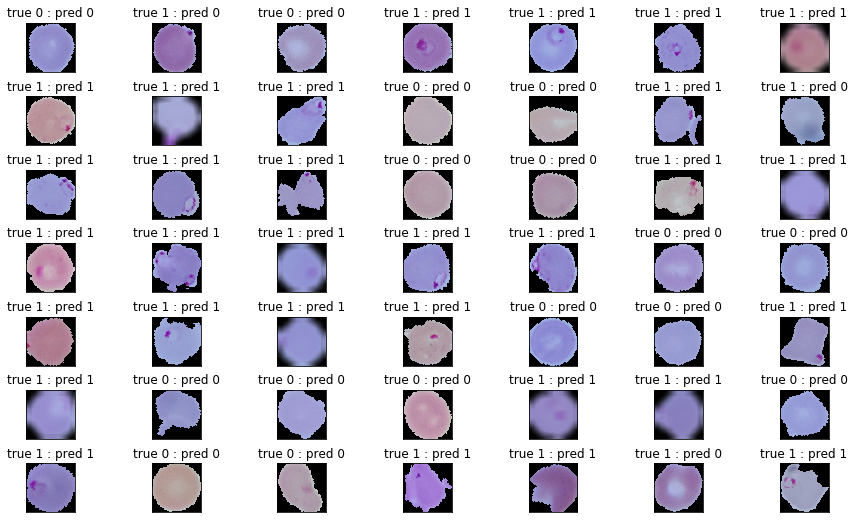

In [23]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y[r[0]] , classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()